##Mount GDrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import the required libraries.
import os
import cv2
import h5py
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

##Change File and locations here

In [17]:
!unzip {weightspath} -d '/content/weights'

Archive:  /content/drive/MyDrive/HDMB51/Weights/convLSTMwith64.zip
 extracting: /content/weights/content/Model weights/Convlstm model/saved_model.pb  
 extracting: /content/weights/content/Model weights/Convlstm model/keras_metadata.pb  
 extracting: /content/weights/content/Model weights/Convlstm model/fingerprint.pb  
 extracting: /content/weights/content/Model weights/Convlstm model/variables/variables.data-00000-of-00001  
 extracting: /content/weights/content/Model weights/Convlstm model/variables/variables.index  


In [65]:
#Specifying the random test video
checkvid2 = 'cycl.mp4'
#Defining PAth
#dataclasspath = '/content/Data/content/Dataset/Converted'

In [5]:
#################################CHanged Here#######################
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
#DATASET_DIR = "/content/Data/content/Dataset/Converted"
CLASSES_LIST = ['Watch_Out', 'No_Threat', 'Threat']

In [6]:
weightspath= '/content/drive/MyDrive/HDMB51/Weights/convLSTMwith64.zip' #specify the location for the model weights
datapath = '/content/drive/MyDrive/HDMB51/HDMP51_converted.zip'  #specify where the data is in your Gdrive
dataseth5filepath = '/content/drive/MyDrive/HDMB51/Dataset/H5 files/dataset.h5' #specify where the H5 file is located

In [7]:
#defining a seed constant to have same random values in different test cases
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

##Function for the frames Extraction

In [8]:
def frames_extraction(video_path):

    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

##Import Dataset file (.h5)

In [9]:
with h5py.File(dataseth5filepath, 'r') as hf:
    features = hf['features'][:]
    labels = hf['labels'][:]
    video_files_paths = hf['video_files_paths'][:]

In [10]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [11]:
# Split the Data into Train  and Test Set ( 3:1 ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

#ConvLSTM Model

In [12]:
def create_convlstm_model():



    model = Sequential()


    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'relu',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))


    model.summary()


    return model

In [13]:
convlstm_model = create_convlstm_model()


print("Model Created")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

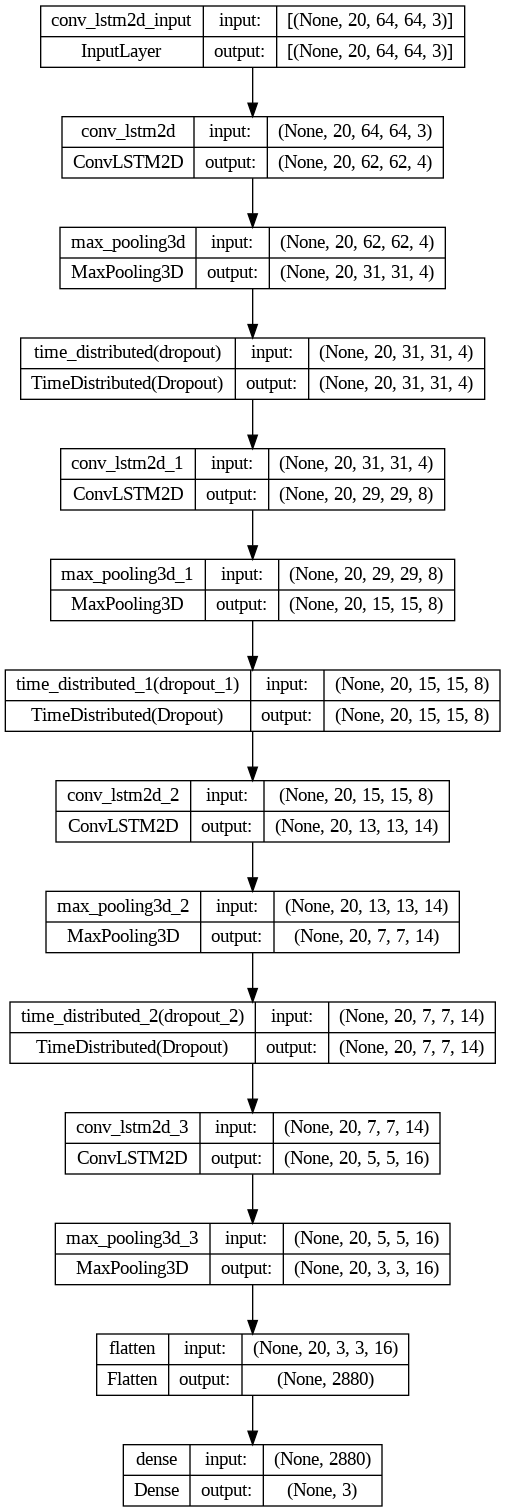

In [14]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [15]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

##To train use this (only use this on pro waala mode)

In [19]:
###Model training###
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 8,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/30
137/137 [==============================] - 24s 178ms/step - loss: 0.7510 - accuracy: 0.6797 - val_loss: 0.8013 - val_accuracy: 0.6655
Epoch 2/30
137/137 [==============================] - 24s 176ms/step - loss: 0.7268 - accuracy: 0.6916 - val_loss: 0.8228 - val_accuracy: 0.6836
Epoch 3/30
137/137 [==============================] - 24s 175ms/step - loss: 0.7090 - accuracy: 0.6971 - val_loss: 0.8199 - val_accuracy: 0.6873
Epoch 4/30
137/137 [==============================] - 24s 177ms/step - loss: 0.6947 - accuracy: 0.6971 - val_loss: 0.8173 - val_accuracy: 0.6655
Epoch 5/30
137/137 [==============================] - 24s 177ms/step - loss: 0.6678 - accuracy: 0.7190 - val_loss: 0.8758 - val_accuracy: 0.6836
Epoch 6/30
137/137 [==============================] - 24s 177ms/step - loss: 0.6321 - accuracy: 0.7245 - val_loss: 0.9811 - val_accuracy: 0.6727
Epoch 7/30
137/137 [==============================] - 24s 178ms/step - loss: 0.6293 - accuracy: 0.7436 - val_loss: 0.8794 - val_ac

##For using weights run this

###make sure to add a weights file for this model when using this

In [ ]:
tf.keras.models.load_model('/content/weights/content/Model weights/Convlstm model')

##Evaluation and stuff


In [20]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

15/15 [==============================] - 1s 53ms/step - loss: 0.8253 - accuracy: 0.6419


In [22]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

In [ ]:
####RUN THIS BLOCK ONLY WHEN YOU WANNA SAVE WEIGHTS
#Saving model files code

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)


model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'


convlstm_model.save(model_file_name)

In [23]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))


    plt.legend()

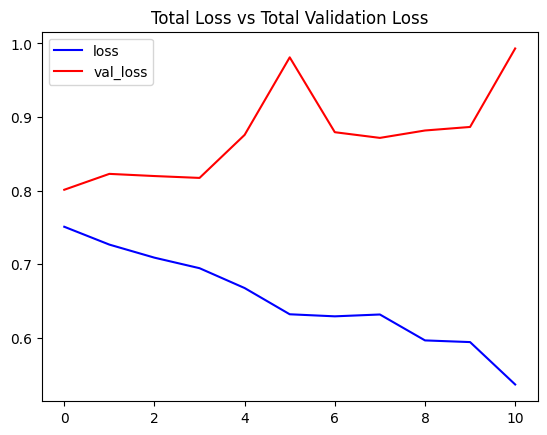

In [24]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

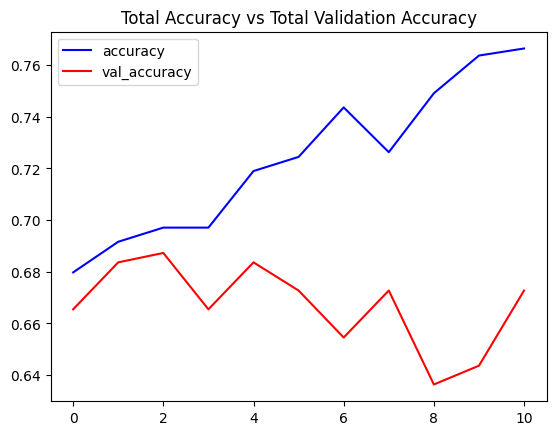

In [25]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

#LRCN Model

In [36]:
def create_LRCN_model():

    model = Sequential()


    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))


    model.summary()

    return model

In [37]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_68 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_69 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_70 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_71 (TimeDi  (None, 20, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_72 (TimeDi  (None, 20, 4, 4, 32)    

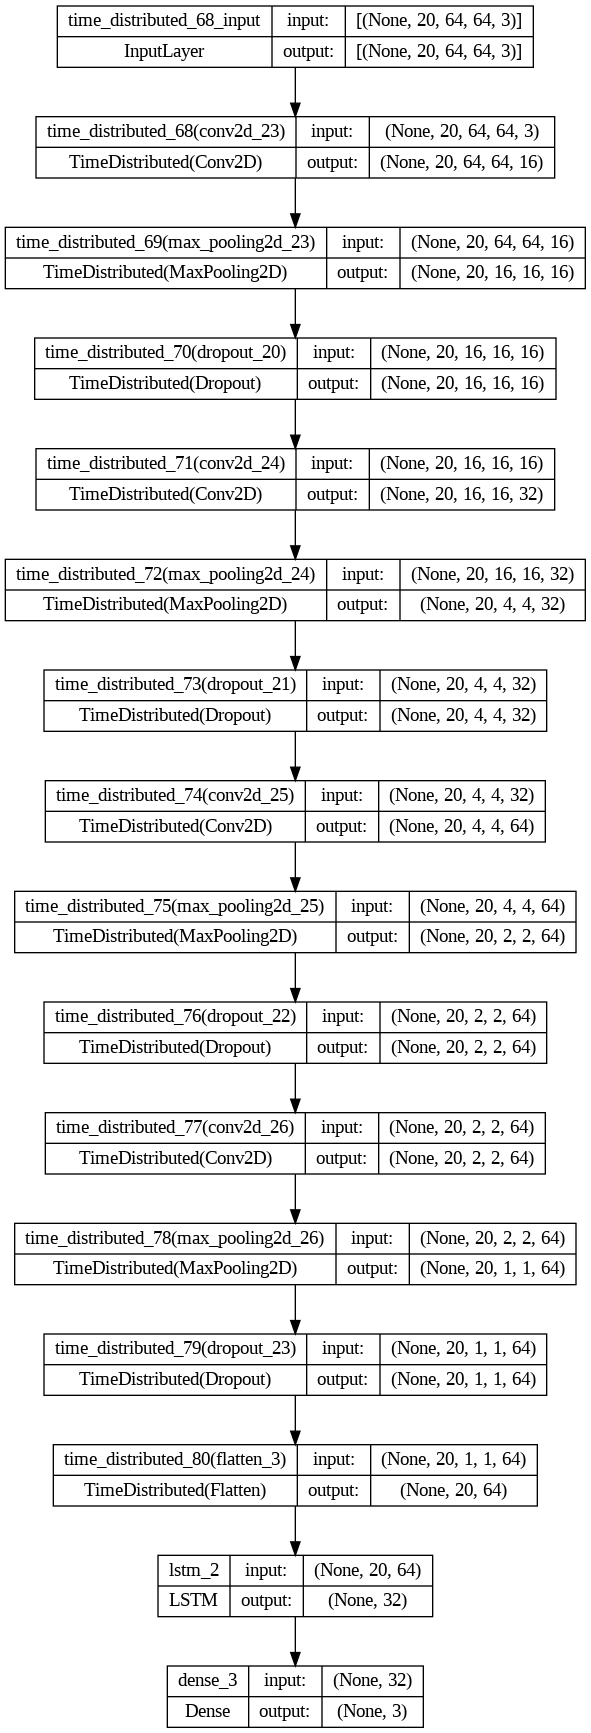

In [38]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [41]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

##To train use this (only use this on pro waala mode)

In [43]:
###Training here###

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
274/274 [==============================] - 2s 8ms/step - loss: 0.4239 - accuracy: 0.8458 - val_loss: 0.8251 - val_accuracy: 0.7309
Epoch 2/70
274/274 [==============================] - 2s 7ms/step - loss: 0.4376 - accuracy: 0.8339 - val_loss: 0.8132 - val_accuracy: 0.7309
Epoch 3/70
274/274 [==============================] - 2s 7ms/step - loss: 0.4246 - accuracy: 0.8394 - val_loss: 0.8186 - val_accuracy: 0.7418
Epoch 4/70
274/274 [==============================] - 2s 7ms/step - loss: 0.3795 - accuracy: 0.8650 - val_loss: 0.8171 - val_accuracy: 0.7673
Epoch 5/70
274/274 [==============================] - 2s 7ms/step - loss: 0.3479 - accuracy: 0.8777 - val_loss: 0.8134 - val_accuracy: 0.7709
Epoch 6/70
274/274 [==============================] - 2s 7ms/step - loss: 0.3459 - accuracy: 0.8832 - val_loss: 1.1391 - val_accuracy: 0.6727
Epoch 7/70
274/274 [==============================] - 2s 7ms/step - loss: 0.3698 - accuracy: 0.8677 - val_loss: 0.8246 - val_accuracy: 0.7491
Epoch 

##For weights use this(should work on any notebook)
###make sure to add a weights file for this model when using this

In [42]:
tf.keras.models.load_model('/content/weights/content/Model weights/LRCNmodel')

##Evaluation and stuff

In [44]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

15/15 [==============================] - 0s 17ms/step - loss: 0.7733 - accuracy: 0.7402


In [45]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

In [46]:
##Saving the model weights


date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
LRCN_model.save(model_file_name)

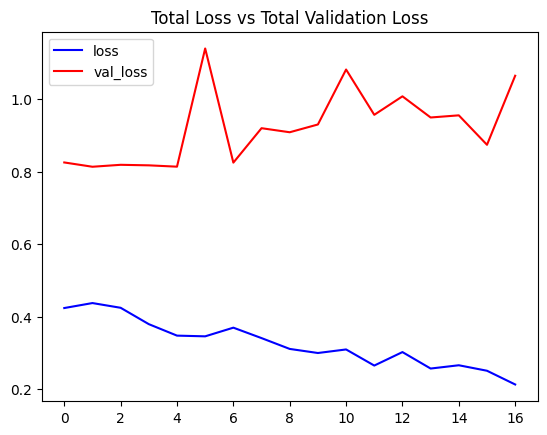

In [47]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

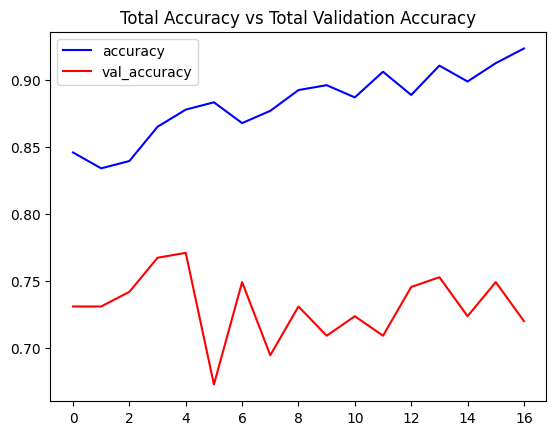

In [48]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

#Testing/ Model Demo

##Defiining test paths

In [68]:
# Make the Output directory if it does not exist

test_videos_directory = '/content/test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

video_title = checkvid2

##Creating a fucntion to perform the action recognition using the model

In [50]:
CLASSES_LIST

['Watch_Out', 'No_Threat', 'Threat']

In [67]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():


        ok, frame = video_reader.read()


        if not ok:   # Check if frame is not read properly then break the loop.
            break

        # Resize
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Add into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the predefined sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:


            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis = 0))[0]   ##Change this line for which model to use

            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()
    return predicted_class_name

##Perform action recognition On the test video

###make sure to define the correct video at the top of this notebook

In [69]:

# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}'#-Output-SeqLen{SEQUENCE_LENGTH}.mp4'


# Perform Action Recognition on the Test Video.
s = predict_on_video(checkvid2, output_video_file_path, SEQUENCE_LENGTH)
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  96%|█████████▌| 125/130 [00:00<00:00, 190.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/test_videos/cycl.mp4, 476100 bytes wanted but 0 bytes read,at frame 128/130, at time 4.27/4.32 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [70]:
s

''